In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import os

In [4]:
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

x_train.shape: (60000, 28, 28)


In [5]:
#flattening the data
N,W,H = x_train.shape
D = H*W
x_train = x_train.reshape(-1,D)
x_test = x_test.reshape(-1,D)

In [6]:
#latent Space Dimension
latent_dim = 100

In [7]:
# generator model architecture
def build_generator(latent_dim):
    i = Input(shape = (latent_dim,))
    x = Dense(256,activation = LeakyReLU(alpha = 0.2))(i)
    x = BatchNormalization(momentum = 0.7)(x)
    x = Dense(512,activation = LeakyReLU(alpha =0.2))(x)
    x = BatchNormalization(momentum = 0.7)(x)
    x = Dense(1024,activation = LeakyReLU(alpha = 0.2))(x)
    x = BatchNormalization(momentum = 0.7)(x)
    x = Dense(D,activation ='tanh')(x)
    
    model = Model(i,x)
    return model

In [8]:
# discriminator model architecture
def build_discriminator(image_size):
    i = Input(shape = (image_size,))
    x = Dense(512,activation = LeakyReLU(alpha = 0.2))(i)
    x = Dense(256, activation = LeakyReLU(alpha = 0.2))(x)
    x = Dense(1,activation = 'sigmoid')(x)
    
    model = Model(i,x)
    return model

In [9]:
#compilation for both model and preparation for training

discriminator = build_discriminator(D)
discriminator.compile(loss ='binary_crossentropy',optimizer =Adam(0.0002,0.5),metrics=['accuracy'])
# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [10]:
# Train the GAN


# Config
batch_size = 32
epochs = 30000
sample_period = 200 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [11]:
# A function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [12]:
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  #######################
  ### Train generator ###
  #######################
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)

1/1 [==============================] - 0s 230ms/step
epoch: 1/30000, d_loss: 0.82,       d_acc: 0.47, g_loss: 0.81
1/1 [==============================] - 0s 16ms/step
epoch: 101/30000, d_loss: 0.02,       d_acc: 1.00, g_loss: 3.59
1/1 [==============================] - 0s 15ms/step
epoch: 201/30000, d_loss: 0.56,       d_acc: 0.67, g_loss: 1.33
1/1 [==============================] - 0s 15ms/step
epoch: 301/30000, d_loss: 0.70,       d_acc: 0.48, g_loss: 0.61
1/1 [==============================] - 0s 30ms/step
epoch: 401/30000, d_loss: 0.68,       d_acc: 0.50, g_loss: 0.64
1/1 [==============================] - 0s 16ms/step
epoch: 501/30000, d_loss: 0.68,       d_acc: 0.48, g_loss: 0.66
1/1 [==============================] - 0s 18ms/step
epoch: 601/30000, d_loss: 0.67,       d_acc: 0.52, g_loss: 0.65
1/1 [==============================] - 0s 16ms/step
epoch: 701/30000, d_loss: 0.68,       d_acc: 0.50, g_loss: 0.67
1/1 [==============================] - 0s 15ms/step
epoch: 801/30000, d_l

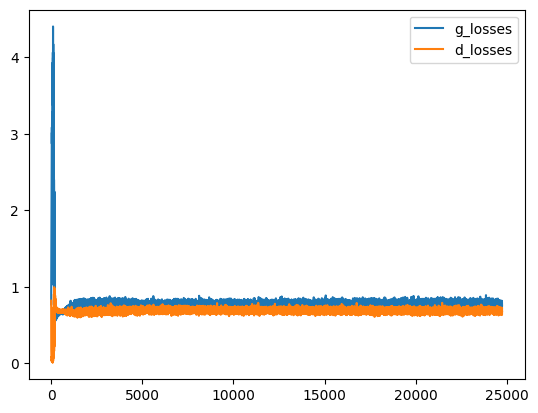

In [13]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [14]:
generator.save('generator.keras')

In [15]:
discriminator.save('discriminator.keras')